# Viz passages

In [31]:
import sys; sys.path.append('../..')
from abslithist.realism import *

In [32]:
anno_fn='../../data/psgs/data.annos.CanonFiction.v4.jsonl'

In [33]:
!prodigy db-out absconc_v4b > $anno_fn

In [34]:
!wc -l $anno_fn

203 ../../data/psgs/data.annos.CanonFiction.v4.jsonl


In [35]:
def parse_anno(anno_fn):
    ld = []

    with open(anno_fn) as f:
        for ln in f:
            d=json.loads(ln)
#             print(d)
            if d['answer']=='ignore': continue
            dx={'passage':d.get('html') if 'html' in d else d.get('text')}
            for k,v in d['meta'].items(): dx[k]=v
            for x in d['accept']: dx[x]=1
            dx['_input_hash']=d['_input_hash']
            dx['_task_hash']=d['_task_hash']
            ld.append(dx)
    df=pd.DataFrame(ld).fillna(0)
    return df

In [36]:
annodf=parse_anno(anno_fn)
annodf

,passage,id,author,title,year,major_genre,canon_genre,slice,source,period,...,OBJDESC,GROTESQUE,INFLATEDSTYLE,DOMESTIC,SLOWTIME,JUDGMENT,PERSABS,EPISTEMOLOGY,COUNSEL,HONOUR
0,", <i><u>rouge</u></i>, and <i><u>lipstick</u><...",Franzen.Corrections,Jonathan Franzen,The Corrections,2001,Novel,Franzen,486,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,himself by making <i>fun</i> of me. So the <i>...,Ferrante.Neapolitan Novels,Ferrante,Neapolitan Novels,2011,Novel,Ferrante,801,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,this great <i><b>crime</b></i> from <i>Venice<...,chadwyck.Cooper.The_Bravo_volume.0136,"Cooper, James Fenimore, 1789-1851","The Bravo, volume 2 (1831)",1831,Novel,,220,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,",--'it my <i><b>fault</b></i>, an please your ...",chadwyck.Sterne.Tristram_Shandy.1085,"Sterne, Laurence, 1713-1768",Tristram Shandy (1760),1760,Novel,Sterne,326,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"it,'' said the <i>pit</i> <i><u>boss</u></i>, ...",markmark.Grisham.The_Summons.1479,"Grisham, John",The Summons,2002,Novel,Grisham,140,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,", and I was about to go on to tell <i><u>Alba<...",markmark.McElroy.Lookout_Cartridge.1570,"McElroy, Joseph",Lookout Cartridge,1973,,,564,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,", it would seem to him as if his very good <i>...",Franzen.Freedom,Jonathan Franzen,Freedom,2010,Novel,Franzen,264,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,. Here was <i><u>Carcasses</u></i> <i>business...,Pepys.Diary,Samuel Pepys,Diary,1660,Other,Pepys,2177,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,", and in this state of great <i>pleasure</i> t...",Montalvo.Amadis of Gaul Vol 2,Montalvo,Amadis of Gaul (vol 2),1508,Romance,“Amadis of Gaul”,141,Median,median,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [37]:
# annodf.iloc[0]

In [38]:
def decideifabs(x):
    if x>=1: return "Abs"
    if x<=-1: return "Conc"
    return "Neither"

In [39]:
def to_plot_df(annodf,biny=100):
    annodf['ybin']=annodf['year'].apply(lambda y: (y//biny*biny) if y>1500 else 1400)
    annodf['zbin2']=annodf['abs-conc_z'].apply(decideifabs)#lambda x: 'Abs' if x>0 else 'Conc')
    annocols = [col for col in annodf.columns if col.upper()==col]
    longanno=annodf.melt(id_vars='_task_hash',value_vars=annocols)
    annodf2=annodf.merge(longanno,on='_task_hash')
    gby=['zbin2','variable','ybin']
#     gby=['variable','ybin']
    plotdf_mean=annodf2.groupby(gby).mean()[['value']]#.reset_index()[['variable','ybin','value']]
    plotdf_sum=annodf2.groupby(gby).sum()[['value']]#.reset_index()[['variable','ybin','value']]
    plotdf=plotdf_mean.join(plotdf_sum,rsuffix='_sum',lsuffix='_mean').reset_index()
    plotdf['value_sum']=plotdf['value_sum'].apply(int)
    return plotdf#[['variable','ybin','value']]


In [40]:
biny=100
annodf['ybin']=annodf['year'].apply(lambda y: (y//biny*biny) if y>1500 else 1400)
annodf['zbin2']=annodf['abs-conc_z'].apply(decideifabs)#lambda x: 'Abs' if x>0 else 'Conc')
counts=annodf.groupby(['ybin','zbin2']).count().reset_index()[['ybin','zbin2','passage']]
# counts

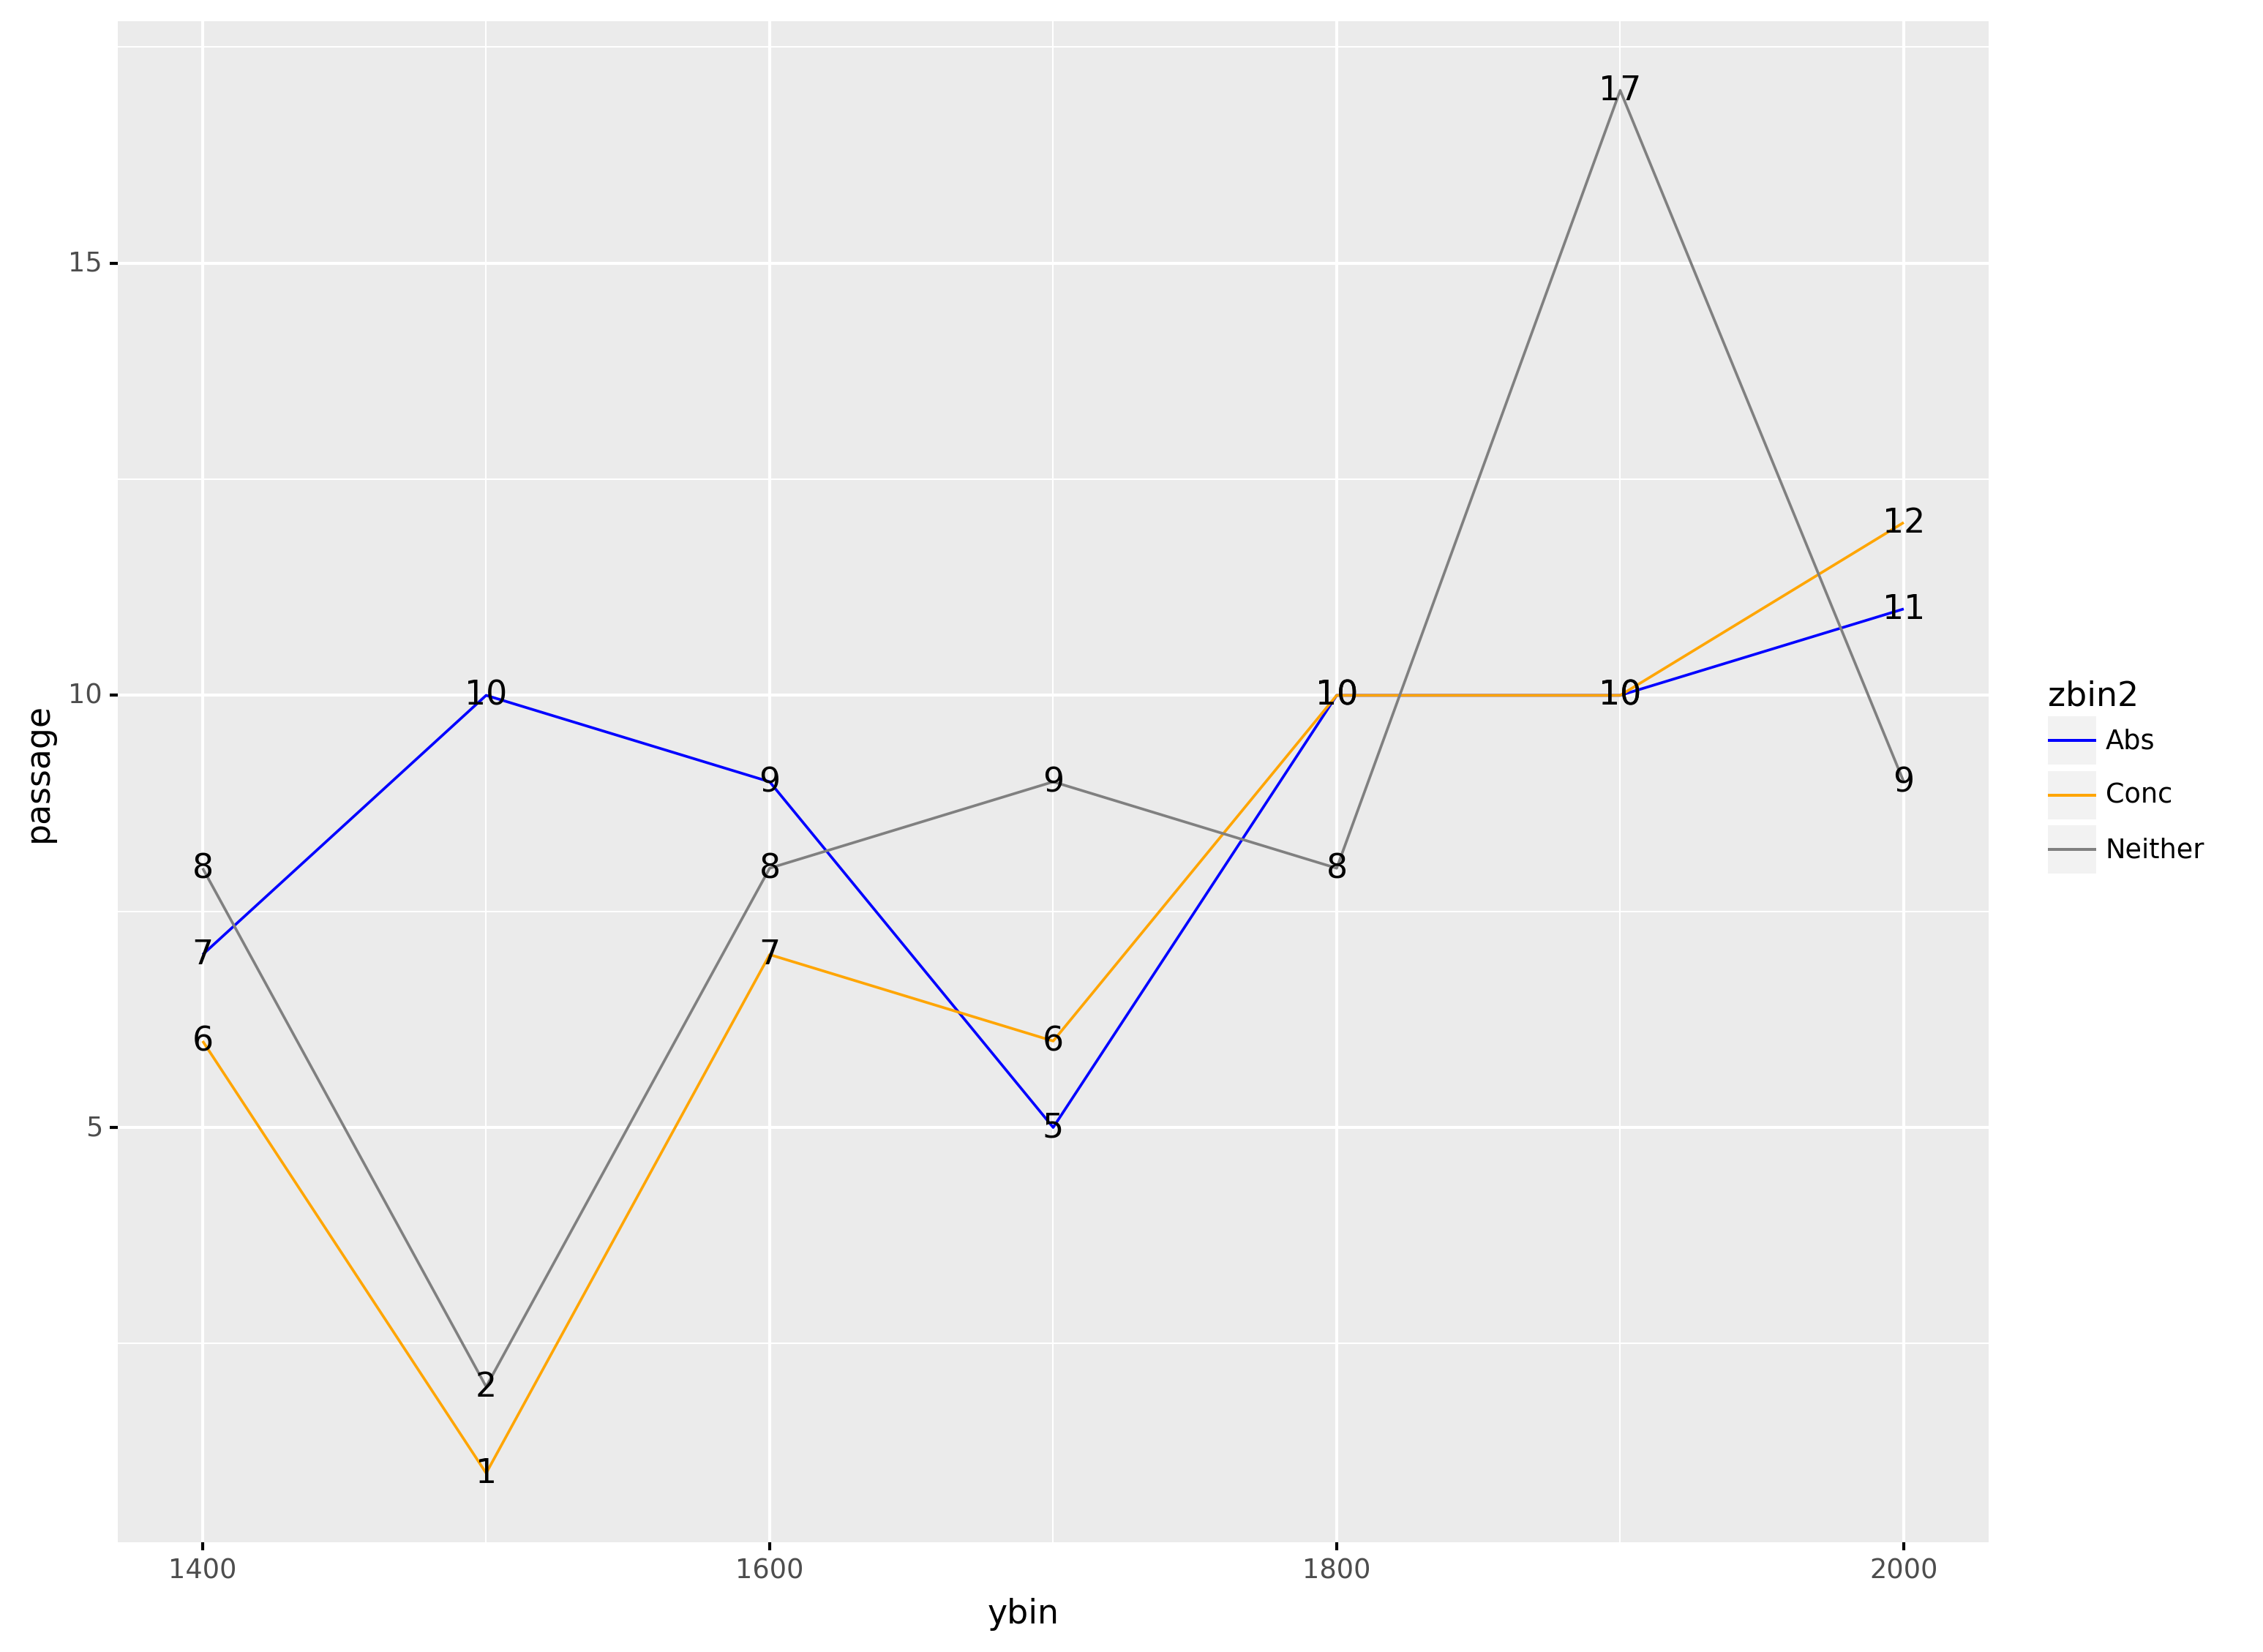

<ggplot: (8743294414889)>

In [41]:
import plotnine as p9
fig=p9.ggplot(p9.aes(x='ybin',y='passage',color='zbin2',label='passage'),data=counts)
fig+=p9.geom_line()
fig+=p9.geom_text(color='black')
fig+=p9.scale_color_manual({'Abs':'blue','Conc':'orange','Neither':'gray'})
fig

In [42]:
plotdf=to_plot_df(annodf)
plotdf.sort_values('value_mean')
# plotdf.zbin2.value_counts()

,zbin2,variable,ybin,value_mean,value_sum
304,Conc,HONOUR,1700,0.000000,0
310,Conc,INFERENCE,1600,0.000000,0
309,Conc,INFERENCE,1500,0.000000,0
308,Conc,INFERENCE,1400,0.000000,0
307,Conc,HONOUR,2000,0.000000,0
...,...,...,...,...,...
177,Abs,PROPRIETY,1600,0.777778,7
377,Conc,PLACEDESC,2000,0.833333,10
211,Conc,ACTION,1500,1.000000,1
372,Conc,PLACEDESC,1500,1.000000,1


In [43]:
plotdf[plotdf.ybin==1500].sort_values('variable')

,zbin2,variable,ybin,value_mean,value_sum
1,Abs,ABSGEN,1500,0.1,1
407,Neither,ABSGEN,1500,0.5,1
204,Conc,ABSGEN,1500,0.0,0
8,Abs,ACTION,1500,0.0,0
414,Neither,ACTION,1500,0.0,0
...,...,...,...,...,...
190,Abs,SLOWTIME,1500,0.0,0
393,Conc,SLOWTIME,1500,0.0,0
400,Conc,SOCIALANALYSIS,1500,0.0,0
197,Abs,SOCIALANALYSIS,1500,0.1,1


In [44]:
def plot_anno(plotdf,biny=100):
    import plotnine as p9
    p9.options.figure_size=(11,9)
    fig=p9.ggplot(p9.aes(x='ybin',y='value_mean',label='value_sum',color='zbin2'), data=plotdf)
#     fig=p9.ggplot(p9.aes(x='ybin',y='value_mean',label='value_sum'), data=plotdf)
#     fig+=p9.geom_point()
    fig+=p9.geom_line()
    fig+=p9.geom_text(size=6,fontweight="bold",color='black')
#     fig+=p9.geom_boxplot()
    fig+=p9.facet_wrap('variable')
    fig+=p9.scale_color_manual({'Abs':'blue','Conc':'orange','Neither':'gray'})
    return fig

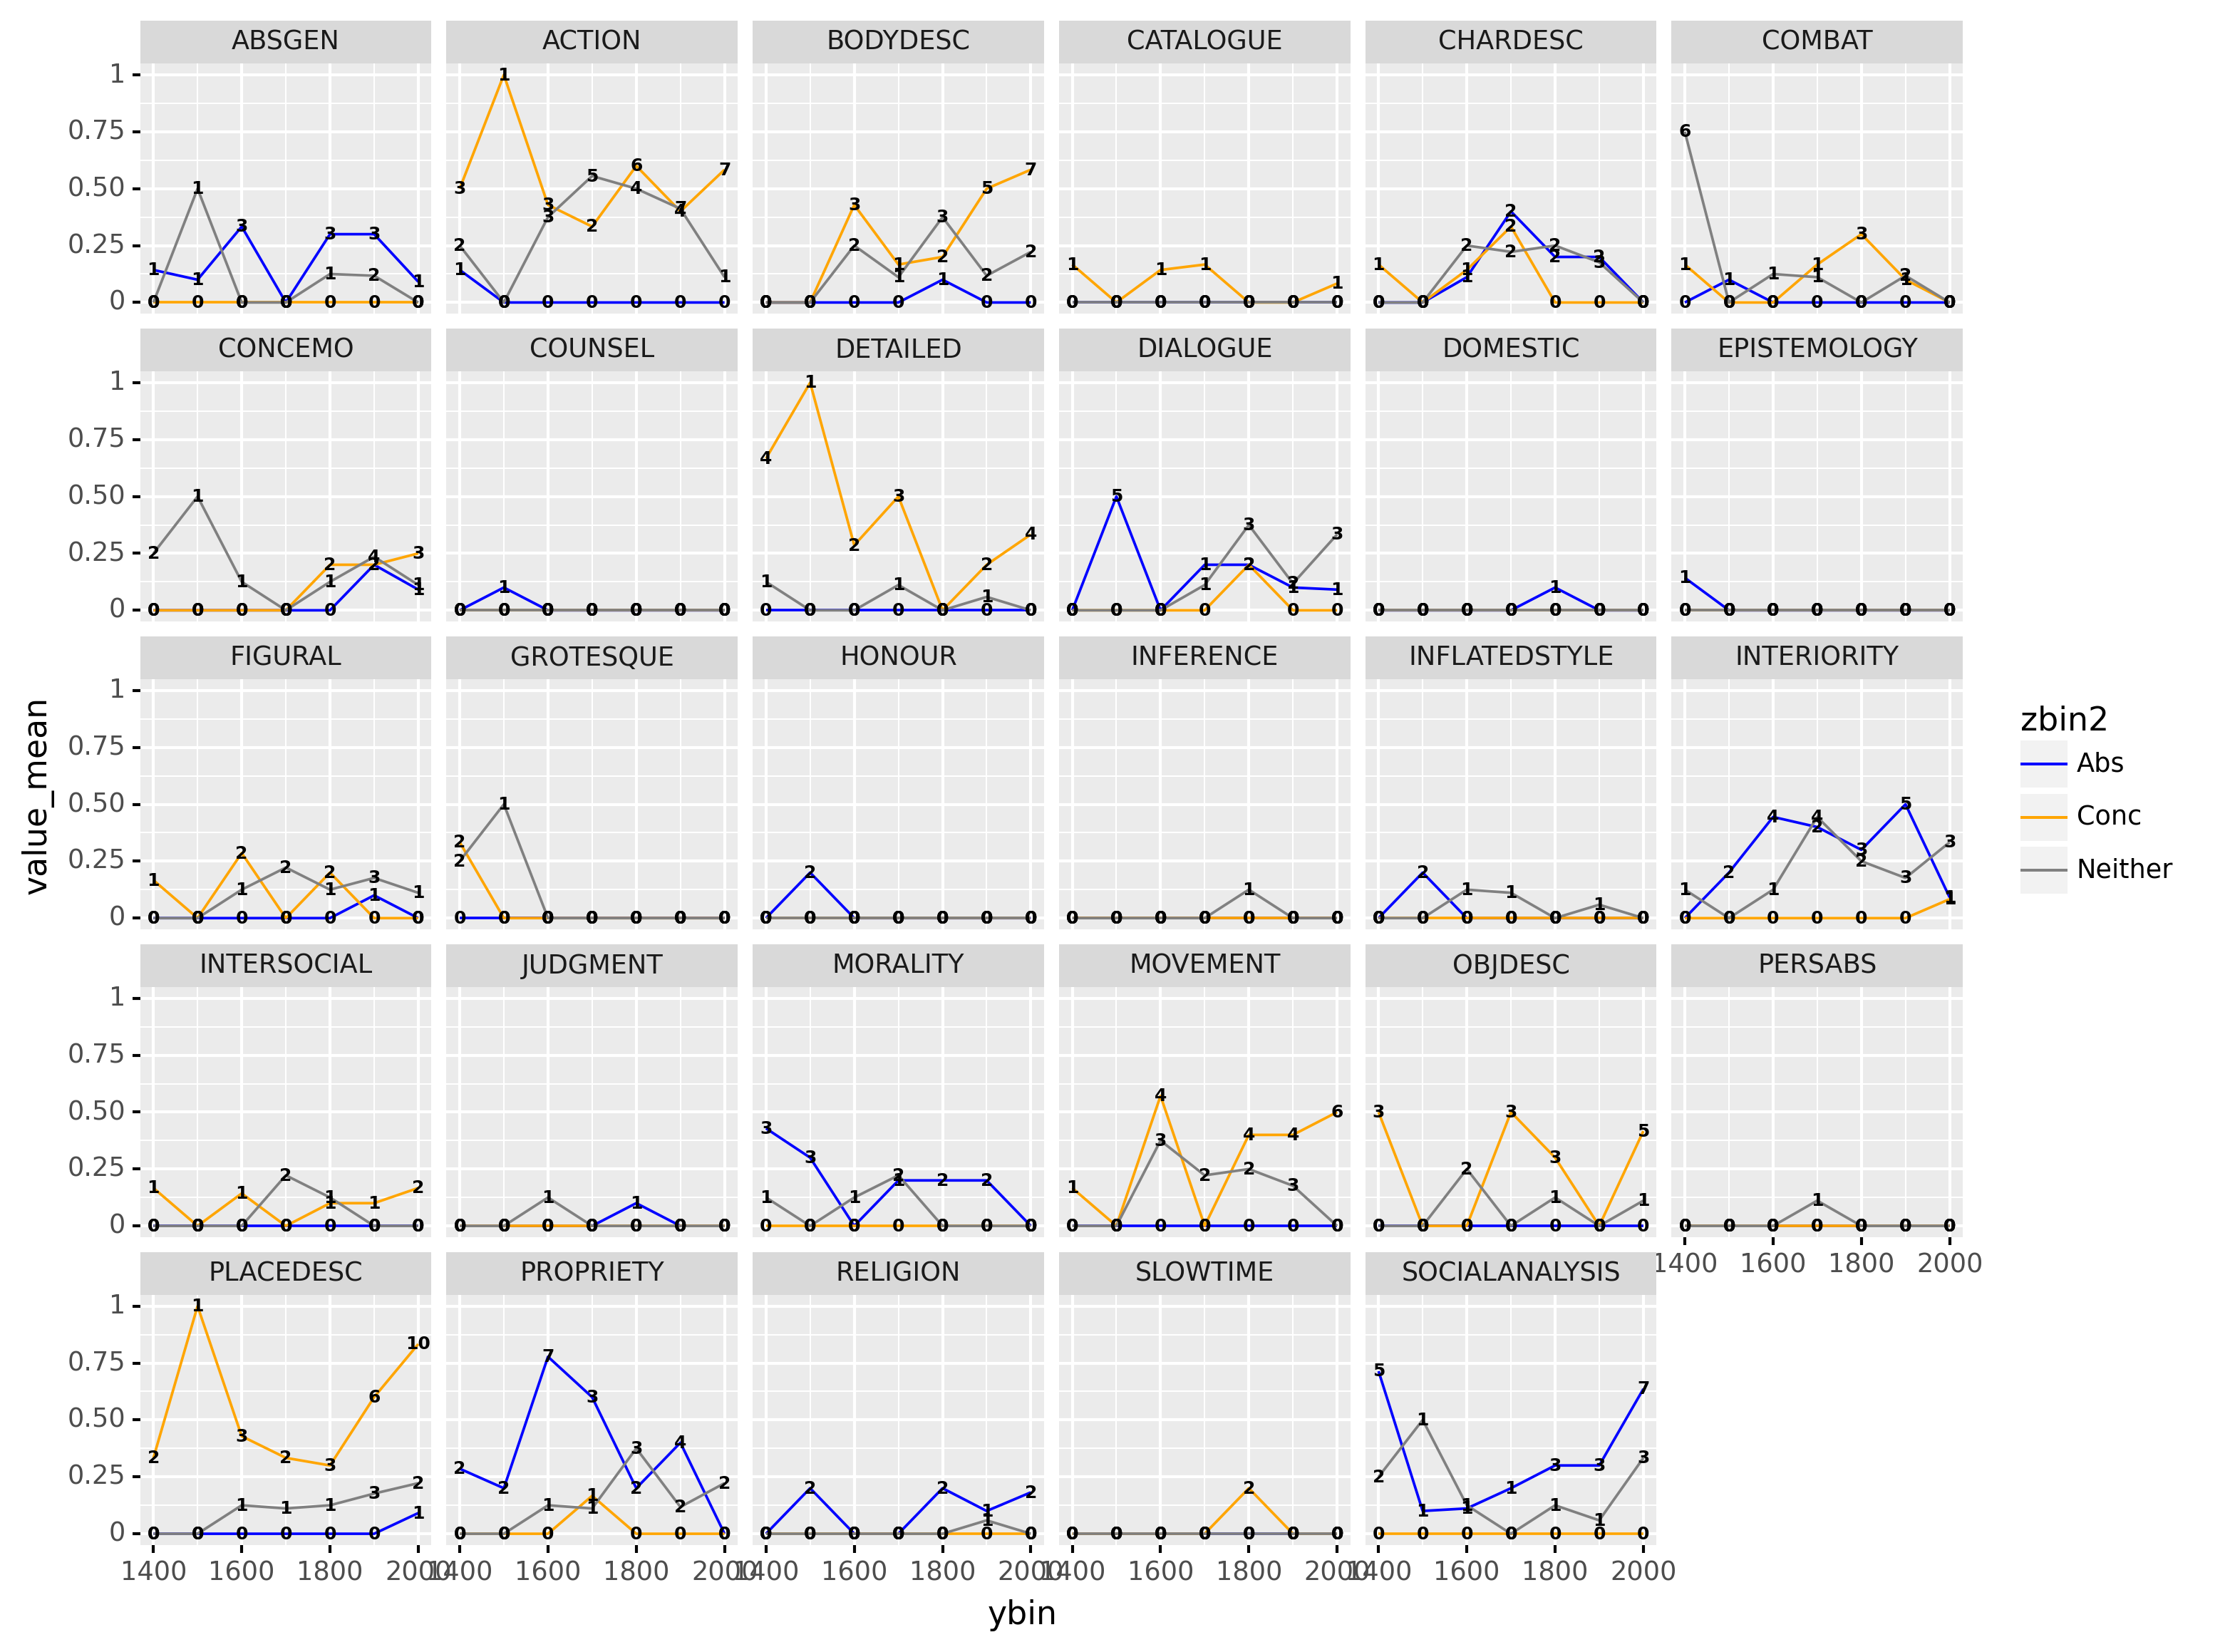

<ggplot: (8743294414161)>

In [45]:
plot_anno(plotdf)